# Text representation and feature extraction from FOMC statments 

In [1]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import scipy

from matplotlib import pyplot as plt
from skfin.plot import bar, line

In the previous section, we focused only on the dates of Federal Open Market Committee (FOMC) statements. We now turn to the task of extracting information from these statements -- in particular by providing a vector representation of each document.

Representations of text have evolved significantly over time, starting from simple approaches such as the bag of words model, which treats text as an unordered collection of words and relies on exogenous dictionaries to map words to features. This method, however, lacks context and semantic understanding.

To address these limitations, sparse representations like Term Frequency-Inverse Document Frequency (TF-IDF) were developed, which weigh words based on their importance across documents. These sparse matrices can be transformed into dense representations using techniques like Principal Component Analysis (PCA), Non-negative Matrix Factorization (NMF), or k-means clustering, improving efficiency and interpretability. 

More recently, advances in natural language processing have led to the emergence of dense representations through encoder transformer language models, such as BERT and GPT. These models capture deep contextual and semantic information by encoding words in multiple dimensions, revolutionizing how text is understood and processed in computational linguistics.

## Loading the FOMC statements 

As discussed in the previous section, the FOMC statements can be loaded with the function `load_fomc_statements` and inspected with the function `show_text`.

In [2]:
from skfin.datasets_ import load_fomc_statements
from skfin.text import show_text, plot_document_embeddings, plot_word_embeddings

statements = load_fomc_statements(force_reload=False)

INFO:skfin.dataloaders.cache:Loading from cache : data/fomc_statements.parquet


In [3]:
special_days = ["2008-01-22", "2010-05-09", "2020-03-15"]

In [4]:
show_text(statements.loc[special_days], n=3)

,last_update,text,voting,release_time,url
release_date,,,,,
2008-01-22,2008-01-22,"The Federal Open Market Committee has decided to lower its target for the federal funds rate 75 basis points to 3-1/2 percent. The Committee took this action in view of a weakening of the economic outlook and increasing downside risks to growth. While strains in short-term funding markets have eased somewhat, broader financial market conditions have continued to deteriorate and credit has tightened further for some businesses and households. Moreover, incoming information indicates a deepening of the housing contraction as well as some softening in labor markets. The Committee expects inflation to moderate in coming quarters, but it will be necessary to continue to monitor inflation developments carefully. Appreciable downside risks to growth remain. The Committee will continue to assess the effects of financial and other developments on economic prospects and will act in a timely manner as needed to address those risks.","Voting for the FOMC monetary policy action were: Ben S. Bernanke, Chairman; Timothy F. Geithner, Vice Chairman; Charles L. Evans; Thomas M. Hoenig; Donald L. Kohn; Randall S. Kroszner; Eric S. Rosengren; and Kevin M. Warsh. Voting against was William Poole, who did not believe that current conditions justified policy action before the regularly scheduled meeting next week. Absent and not voting was Frederic S. Mishkin.",For immediate release,https://www.federalreserve.gov/newsevents/press/monetary/20080122b.htm
2010-05-09,2010-05-10,"In response to the reemergence of strains in U.S. dollar short-term funding markets in Europe, the Bank of Canada, the Bank of England, the European Central Bank, the Federal Reserve, and the Swiss National Bank are announcing the reestablishment of temporary U.S. dollar liquidity swap facilities. These facilities are designed to help improve liquidity conditions in U.S. dollar funding markets and to prevent the spread of strains to other markets and financial centers. The Bank of Japan will be considering similar measures soon. Central banks will continue to work together closely as needed to address pressures in funding markets. The Federal Open Market Committee has authorized temporary reciprocal currency arrangements (swap lines) with the Bank of Canada, the Bank of England, the European Central Bank (ECB), and the Swiss National Bank. The arrangements with the Bank of England, the ECB, and the Swiss National Bank will provide these central banks with the capacity to conduct tenders of U.S. dollars in their local markets at fixed rates for full allotment, similar to arrangements that had been in place previously. The arrangement with the Bank of Canada would support drawings of up to \$30 billion, as was the case previously. These swap arrangements have been authorized through January 2011. Further details on these arrangements will be available shortly. Information on the actions that will be taken by other central banks is available at the following websites:",,For release at 9:15 p.m. EDT,https://www.federalreserve.gov/newsevents/press/monetary/20100509a.htm
2020-03-15,2020-03-15,"The coronavirus outbreak has harmed communities and disrupted economic activity in many countries, including the United States. Global financial conditions have also been significantly affected. Available economic data show that the U.S. economy came into this challenging period on a strong footing. Information received since the Federal Open Market Committee met in January indicates that the labor market remained strong through February and economic activity rose at a moderate rate. Job gains have been solid, on average, in recent months, and the unemployment rate has remained low. Although household spending rose at a moderate pace, business fixed investment and exports remained weak. More recently, the energy sector has come under stress. On a 12âmonth basis, overall inflation and inflation for items other th

## Bag of words: Sentiment in FOMC statements

In this section, we measure sentiment with the Loughran-McDonalds sentiment dictionary in two ways: 

- sentiment = (#positive - #negative)/(#positive + #negative)
- sentiment = (#positive - #negative)/(#words)

In the first case, short documents (with few or no sentiment words) might lead to biased estimates. 

In [5]:
import pandas as pd
from skfin.datasets_ import load_fomc_statements, load_loughran_mcdonald_dictionary
from skfin.plot import line
from skfin.text import coefs_plot, show_text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [6]:
statements = load_fomc_statements()
lm = load_loughran_mcdonald_dictionary()

INFO:skfin.dataloaders.cache:Loading from cache : data/fomc_statements.parquet


INFO:skfin.dataloaders.cache:Loading from cache : data/Loughran-McDonald_MasterDictionary_1993-2021.csv


In [7]:
lm

,Word,Seq_num,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Syllables,Source
0,AARDVARK,1,354,1.550080e-08,1.422600e-08,3.815486e-06,99,0,0,0,0,0,0,0,2,12of12inf
1,AARDVARKS,2,3,1.313627e-10,8.653817e-12,9.241714e-09,1,0,0,0,0,0,0,0,2,12of12inf
2,ABACI,3,9,3.940882e-10,1.169679e-10,5.290465e-08,7,0,0,0,0,0,0,0,3,12of12inf
3,ABACK,4,29,1.269840e-09,6.654735e-10,1.595100e-07,28,0,0,0,0,0,0,0,2,12of12inf
4,ABACUS,5,8570,3.752595e-07,3.809464e-07,3.529356e-05,1108,0,0,0,0,0,0,0,3,12of12inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86526,ZYGOTE,86529,50,2.189379e-09,8.729336e-10,1.886011e-07,35,0,0,0,0,0,0,0,2,12of12inf
86527,ZYGOTES,86530,1,4.378757e-11,1.809516e-11,1.932446e-08,1,0,0,0,0,0,0,0,2,12of12inf
86528,ZYGOTIC,86531,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,3,12of12inf
86529,ZYMURGIES,86532,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,3,12of12inf


In [8]:
X = statements["text"]

In [9]:
funcs = {
    "negative": lambda x: x.Negative > 0,
    "positive": lambda x: x.Positive > 0,
    "all": lambda x: x.Word.notna(),
}


def get_total_count(X, lm, func):
    m = CountVectorizer(vocabulary=lm.loc[func].Word.str.lower().values)
    return pd.DataFrame(m.fit_transform(X).toarray(), index=X.index).sum(axis=1)


lm_counts = pd.concat({k: get_total_count(X, lm, v) for k, v in funcs.items()}, axis=1)

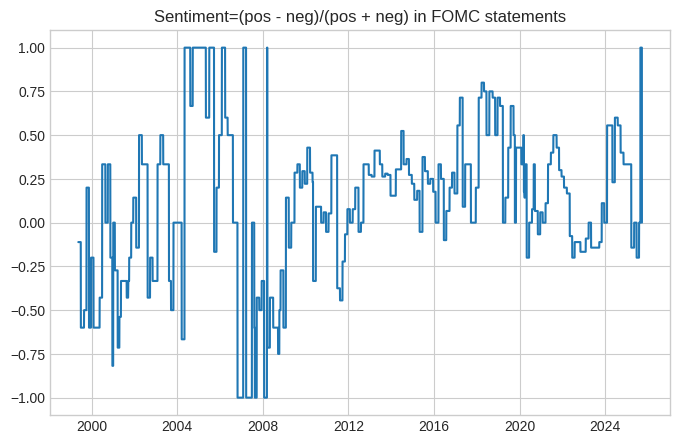

In [10]:
line(
    lm_counts.pipe(lambda x: (x.positive - x.negative) / (x.positive + x.negative))
    .resample("B")
    .last()
    .ffill(),
    legend=False,
    title="Sentiment=(pos - neg)/(pos + neg) in FOMC statements",
)

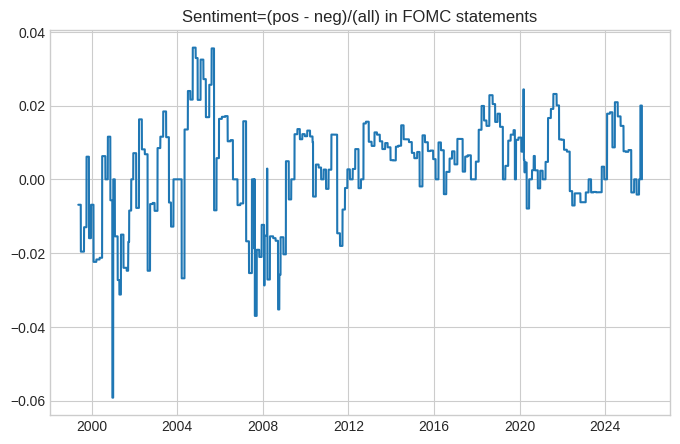

In [11]:
line(
    lm_counts.pipe(lambda x: (x.positive - x.negative) / x["all"])
    .resample("B")
    .last()
    .ffill(),
    legend=False,
    title="Sentiment=(pos - neg)/(all) in FOMC statements",
)

In [12]:
lm_lexica = {
    "negative": pd.Series(1, lm.loc[lm.Negative > 0].Word.str.lower().values),
    "positive": pd.Series(1, lm.loc[lm.Positive > 0].Word.str.lower().values),
}
show_text(
    statements.loc[["2000-12-19", "2013-12-18", "2014-01-29"]], lexica=lm_lexica, n=None
)

## Sparse text representation: TFIDF

The progress of Natural Language Processing has been based on coming up with progressively better representations of text. In this section, we first discuss "word counting" in a given corpus and then embedding derived from pretrained language models. 

In order to extract features from text, the simplest way is to count words. In `scikit-learn`, this is done with the function `CountVectorizer`. A slightly more advanced feature is to select words based on a `TFIDF` score, defined as the product of the term frequency (`TF`) and the inverse document frequency (`IDF`). More precisely, the `TFIDF` score trades off: 
- the terms that are frequent and therefore important in a corpus: 
- the terms that appear in almost all documents and therefore are not helping to discriminate across documents. 

In `TfidfVectorizer`, terms can be filtered additionally with: 
- a `stop word` list
- min and max document frequencies or counts 
- some token pattern (e.g. that eliminates the short tokens). 

In [13]:
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [14]:
vectorizer = TfidfVectorizer(
    stop_words="english",
    min_df=5,
    max_df=0.8,
    ngram_range=(1, 3),
    token_pattern=r"\b[a-zA-Z]{3,}\b",
)
X_ = vectorizer.fit_transform(statements["text"].values)

In [15]:
cols = vectorizer.get_feature_names_out()
print(len(cols))
list(cols)[:10]

4355


['abate',
 'abating',
 'abroad',
 'accommodation',
 'accommodation balanced',
 'accommodation balanced approach',
 'accommodation economic',
 'accommodation economic activity',
 'accommodation economic growth',
 'accommodation removed']

In what follows, to reduce the impact over large  `tfidf` coefficients, we use the log transformationl $x \mapsto log(1+x)$ 

In [16]:
X_tfidf = pd.DataFrame(
    np.log1p(X_.toarray()), index=statements["text"].index, columns=cols
)

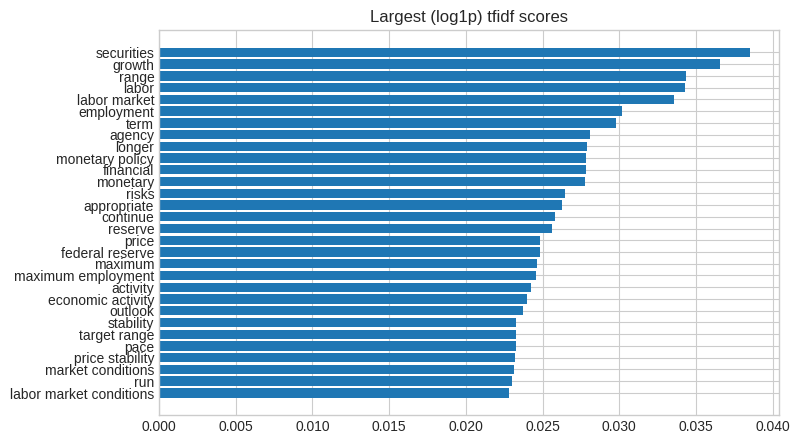

In [17]:
bar(
    X_tfidf.mean().sort_values(ascending=False).head(30),
    horizontal=True,
    title="Largest (log1p) tfidf scores",
)

### Principal component exploration

In terms of representation of text, one key feature of the `tfidf` representation is that it is very sparse (with many zeros). For the `tfidf` representation $X$ (where each row is a document and each column is an n-gram term out of the tfidf), the idea of a low-rank approximation is $\hat{X}$ and $H$ such that $$ X \approx \hat{X} H^T, $$ 

where $\hat{X}$ is a "denser" matrix than $X$ because intuitively, some columns have been combined. 

We first perform Principal Component Analysis (`PCA`) using the singular-value decomposition (`svd`) function in `numpy`. 

In [18]:
u, s, w = np.linalg.svd(X_tfidf)

A singular value decomposition yields: $$X = U \times Diag (s) \times W^T, $$

where $s$ is the vector of eigenvalues and $U$ and $W$ are the matrix of eigenvectors. For a number of modes $n$, define: $s_n$ the vector with the first (largest) $n$ eivenvalues; and $U_n$ and $W_n$ the first $n$ columns of $U$ and $W$. 

Then with $\hat{X} = U_n \times Diag(\sqrt{s_n})$ and $H_n =  W_n \times Diag(\sqrt{s_n})$, we have: 

$$X \approx \hat{X} H_n^T.$$ 

In [19]:
n_modes = 6

signed_sqrt_eigv = np.diag(
    np.sqrt(s[:n_modes]) * np.sign(np.mean(u[:, :n_modes], axis=0))
)
X_pca = pd.DataFrame(u[:, :n_modes].dot(signed_sqrt_eigv), index=statements.index)
H_ = pd.DataFrame(w[:n_modes, :].T.dot(signed_sqrt_eigv), index=cols)

We can compute a distance between the features $X$ and the approximation $\hat{X}_n H_n^T$. More precisely, the Frobinus norm is the sum of squared coefficients of the matrix and it can be computed with `scipy`.

In [20]:
H_

,0,1,2,3,4,5
abate,0.005189,0.033480,0.008402,0.009035,0.041953,-0.010327
abating,0.006477,0.029738,0.005827,0.002243,0.033824,0.003748
abroad,0.011511,0.033658,0.006151,0.002093,0.044256,0.004961
accommodation,0.073431,0.065364,-0.030922,-0.040623,-0.093792,-0.103165
accommodation balanced,0.031124,-0.001260,-0.023675,-0.034508,0.000423,-0.045423
...,...,...,...,...,...,...
years ahead,0.015881,0.001102,-0.009434,-0.027801,-0.000610,-0.024287
years ahead projected,0.015881,0.001102,-0.009434,-0.027801,-0.000610,-0.024287
york,0.014113,0.070823,0.018785,0.015710,0.077104,-0.017272
york philadelphia,0.007276,0.048523,0.011669,0.013798,0.056260,-0.013629


In [21]:
norm_pca = scipy.linalg.norm(X_pca.dot(H_.T).sub(X_tfidf), ord="fro")

In [22]:
np.allclose(norm_pca, np.sqrt(X_pca.dot(H_.T).sub(X_tfidf).pow(2).sum().sum()))

True

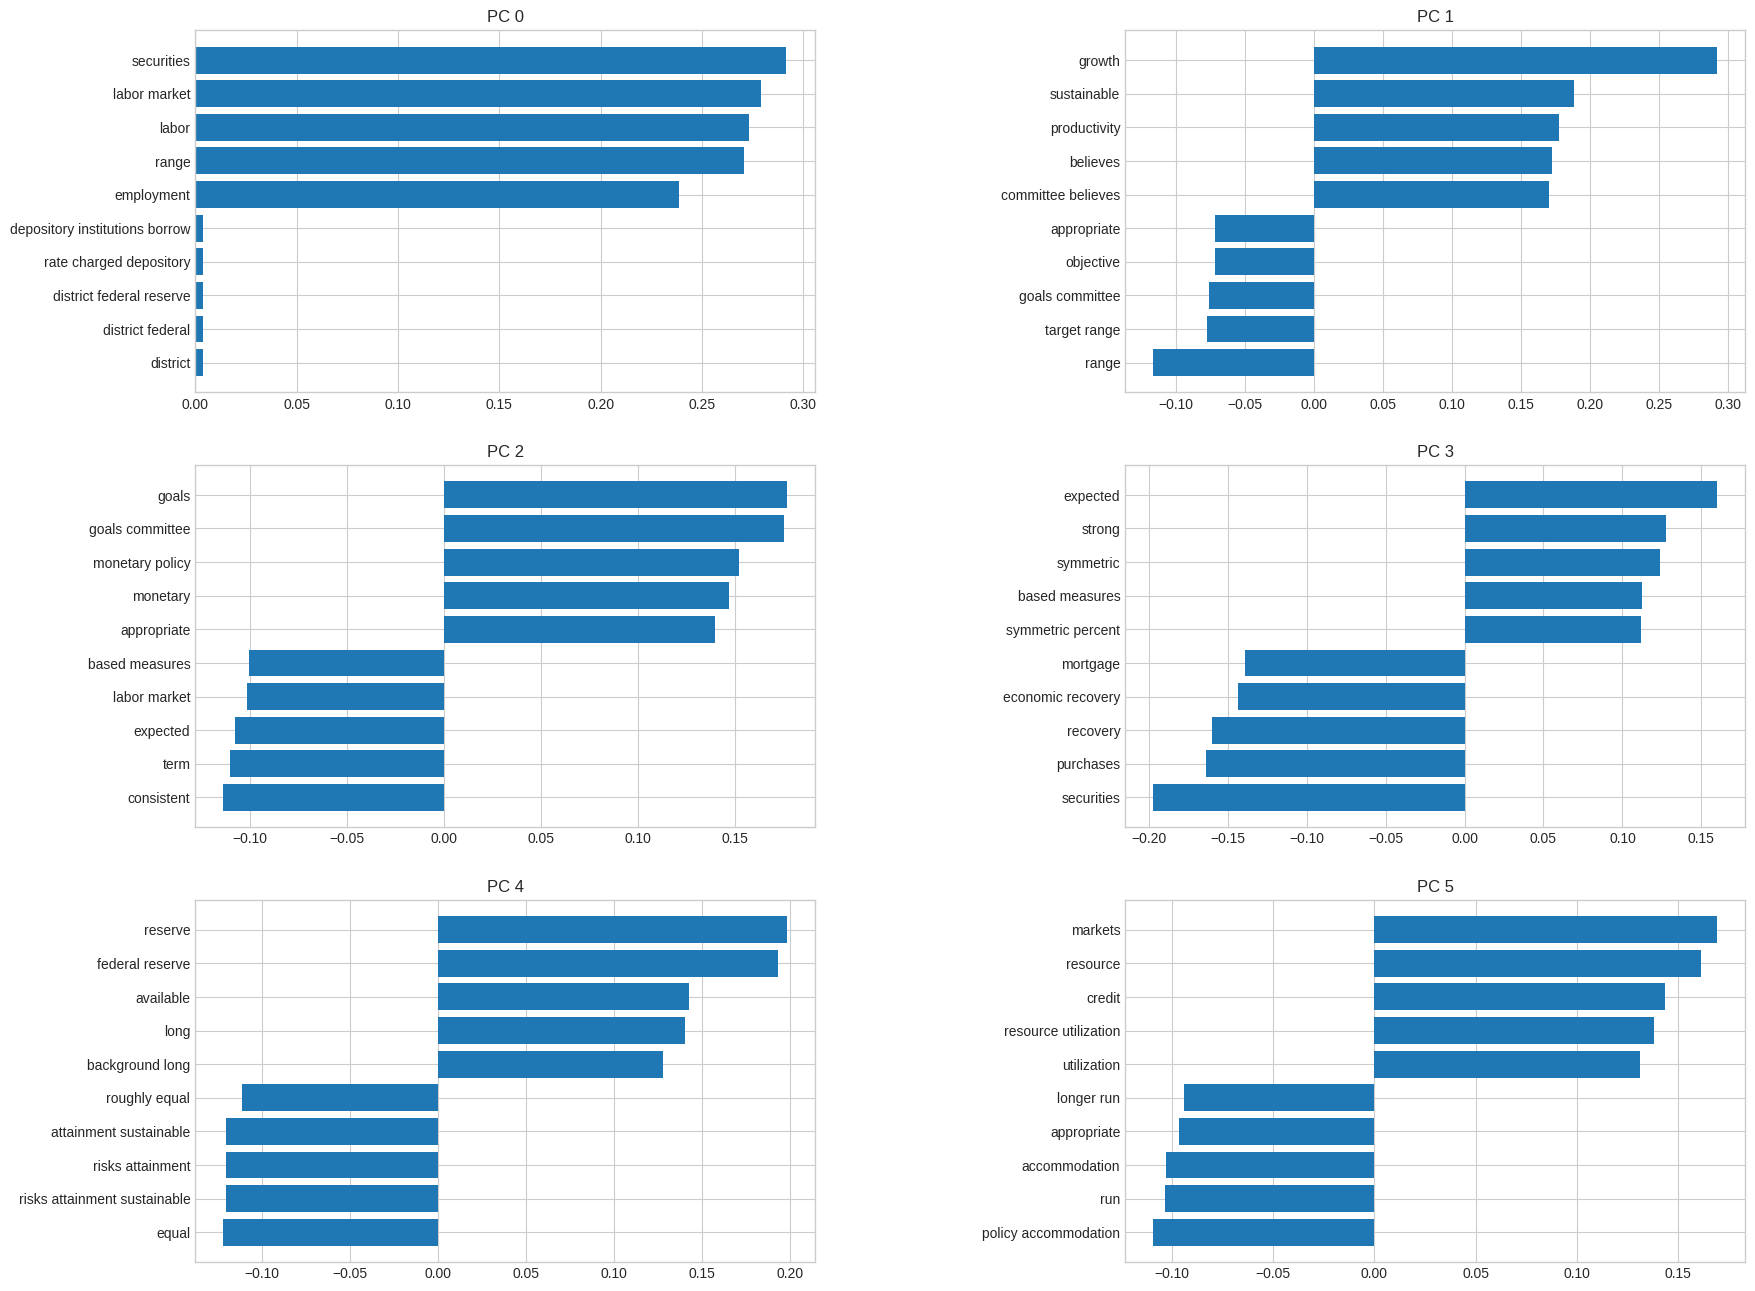

In [23]:
def topbottom(x, n=5):
    return pd.concat([x.nlargest(n=n), x.sort_values(ascending=False).tail(n)])


fig, ax = plt.subplots(int(n_modes / 2), 2, figsize=(20, 16))
ax = ax.ravel()
plt.subplots_adjust(wspace=0.5)
for i in range(n_modes):
    bar(H_[i].pipe(topbottom, n=5), horizontal=True, ax=ax[i], title=f"PC {i}")

The plot above shows that the first principal component `PC0` is related to the labor market and the second principal component `PC1` is relate to economic growth. The graph below shows the loadings on these factor over time by document. 

- in the earlier years (1999-2009), the statements talk more about economic growth (high loading on `PC1`, low loading on `PC0`), but there is a switch in later years (2010-2020). 
- interestingly the last part of the sample (2021-2023) are in the middle and do not seem well explained by the loadings. 

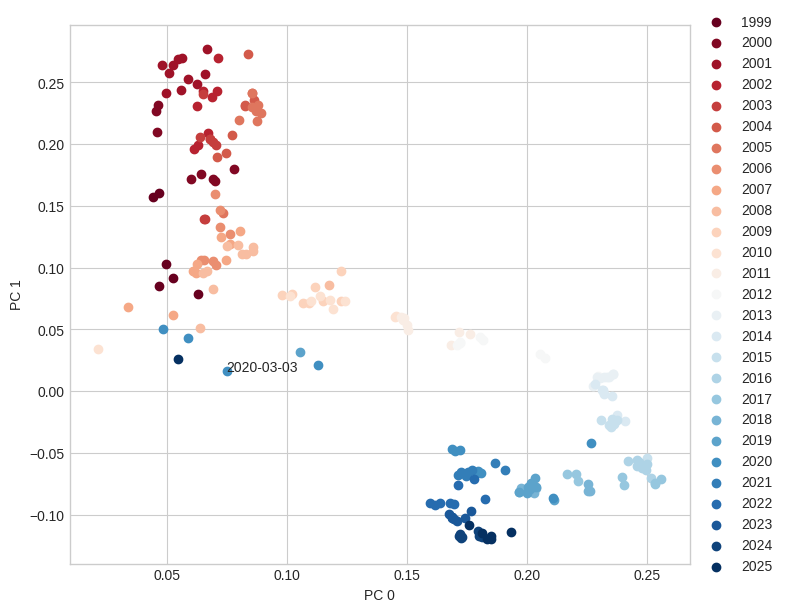

In [24]:
plot_document_embeddings(X_pca)

### Non-negative matrix factorization

### Clustering

In [25]:
m = KMeans(n_clusters=6).fit(X_tfidf)
X_kmeans = pd.get_dummies(pd.Series(m.labels_, index=statements.index))

H3_ = pd.DataFrame(m.cluster_centers_.T, index=cols)
norm_kmeans = scipy.linalg.norm(X_kmeans.dot(H3_.T).sub(X_tfidf), ord="fro")

In [26]:
print(
    f"The norm of the approximations are: pca = {norm_pca:.2f};  kmeans = {norm_kmeans:.2f}."
)

The norm of the approximations are: pca = 11.19;  kmeans = 11.49.


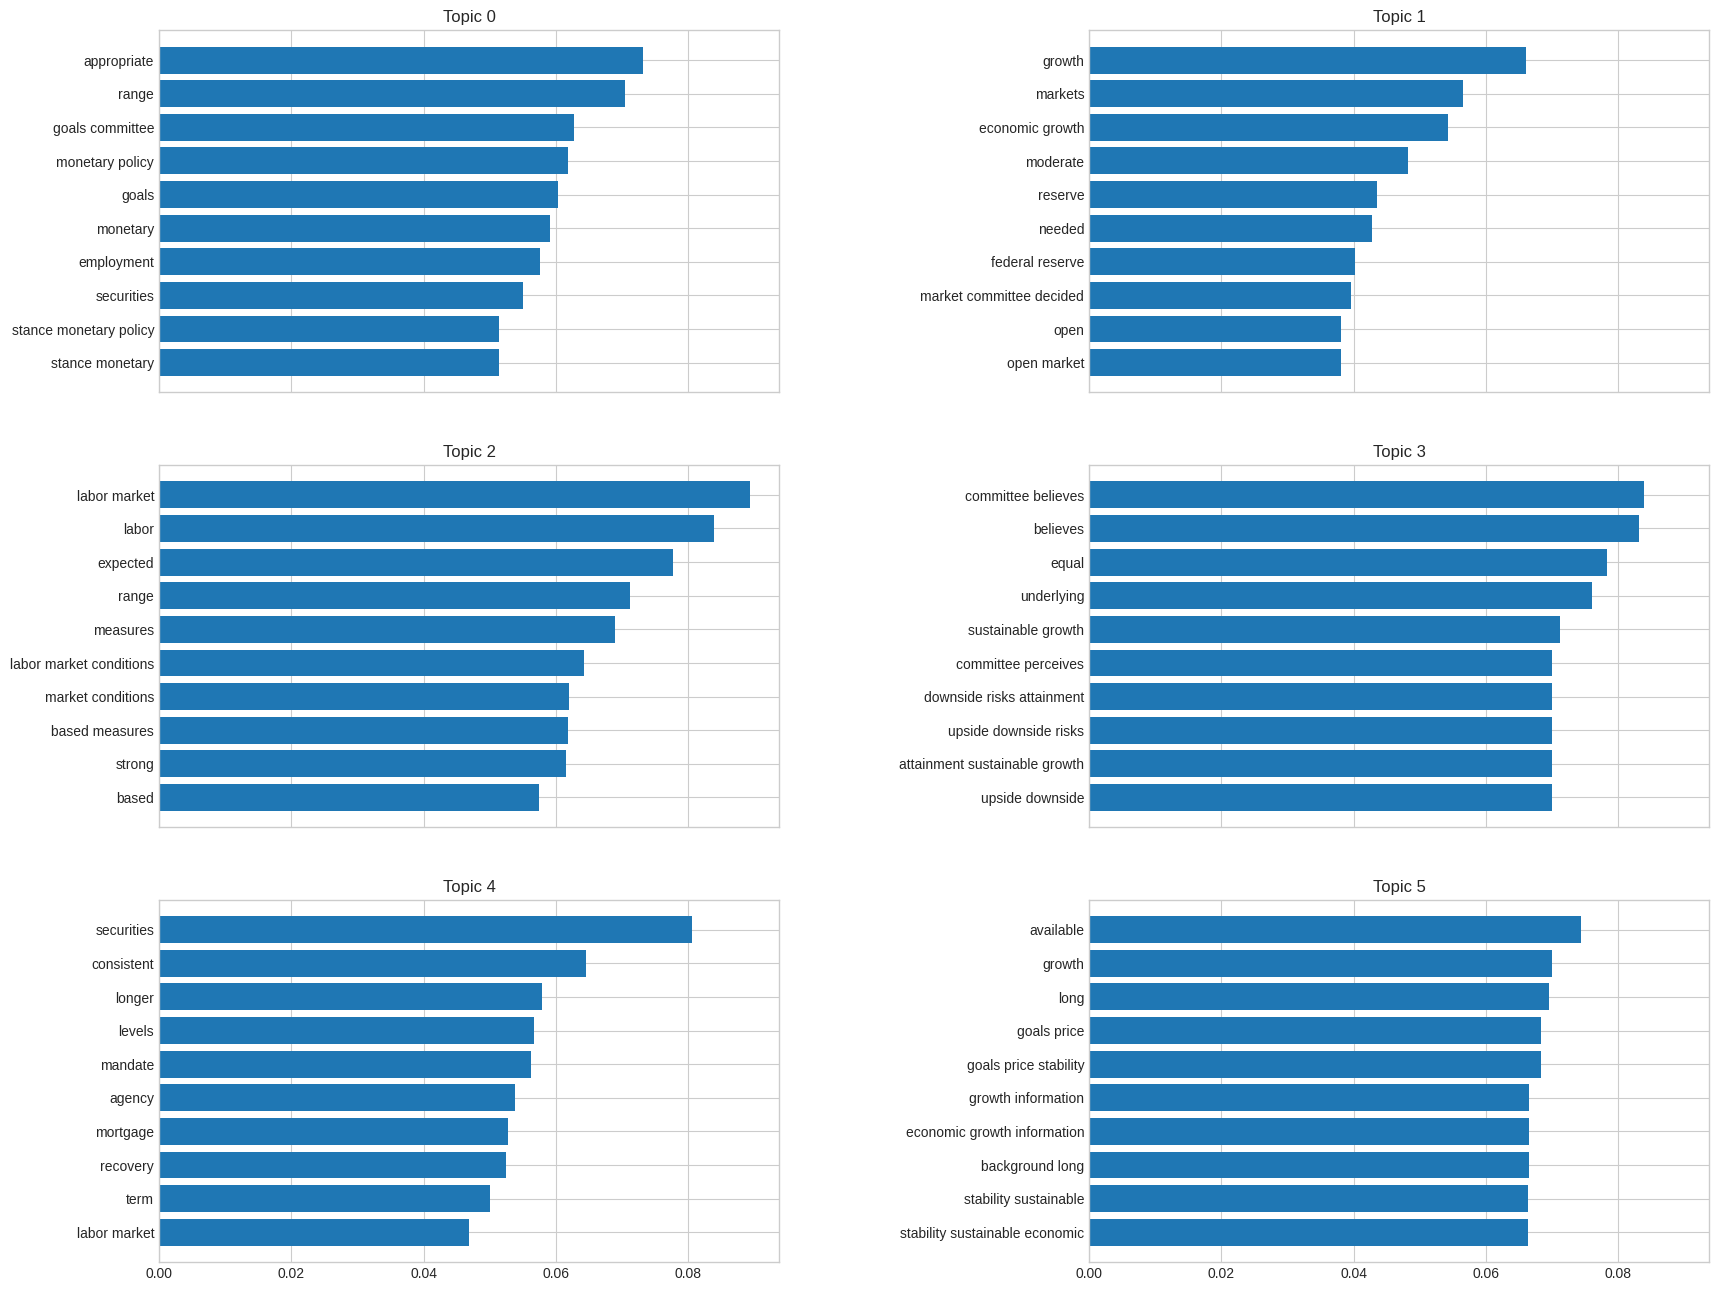

In [27]:
plot_word_embeddings(H3_)

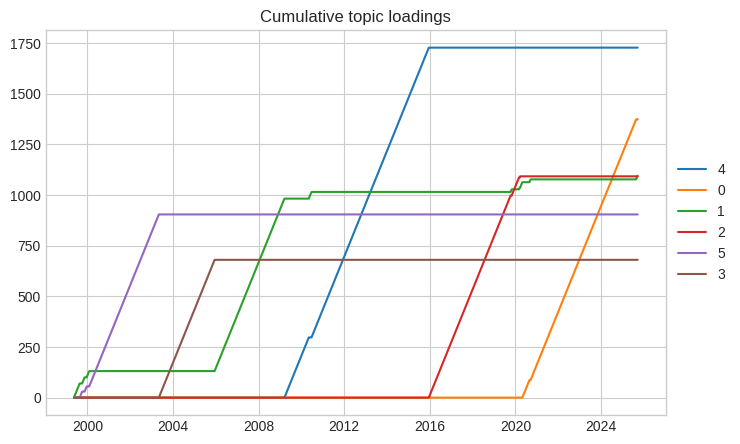

In [28]:
line(
    X_kmeans.resample("B").last().ffill(),
    cumsum=True,
    title="Cumulative topic loadings",
    legend_sharpe_ratio=False,
)

Does the `sentence transformers` embeddings yield a decomposition which is less clustered in time? 

### Non-negative matrix factorization

It is often informative to group tokens into topics that explain differences across documents. A powerful algorithm is the non-negative matrix factorisation (`NMF`): for a non-negative matrix $X$ (such as the one with tfidf scores), `NMF` finds two other non-negative matrices such that $$ X \approx \hat{X}_n H_n^T. $$

The number of topics (called `n_components` in the `scikit-learn` implementation) determines the number of columns in $X_n$ and the number of rows in $H_n$. 

In [29]:
n_components = 6
m = NMF(
    n_components=n_components,
    init="nndsvd",
    solver="cd",
    beta_loss="frobenius",
    random_state=1,
    alpha_W=0,
    l1_ratio=0,
    max_iter=500,
).fit(X_tfidf)

In [30]:
H2_ = pd.DataFrame(m.components_.T, index=cols)
X_nmf = pd.DataFrame(m.transform(X_tfidf), index=statements.index)

The non-negative matrix factorization provides a slightly better approximation as measured by the Frobinus norm. 

In [31]:
norm_nmf = scipy.linalg.norm(X_nmf.dot(H2_.T).sub(X_tfidf), ord="fro")
print(
    f"The norm of the approximations are: pca = {norm_pca:.2f}; ;  kmeans = {norm_kmeans:.2f}; nmf = {norm_nmf:.2f}."
)

The norm of the approximations are: pca = 11.19; ;  kmeans = 11.49; nmf = 11.23.


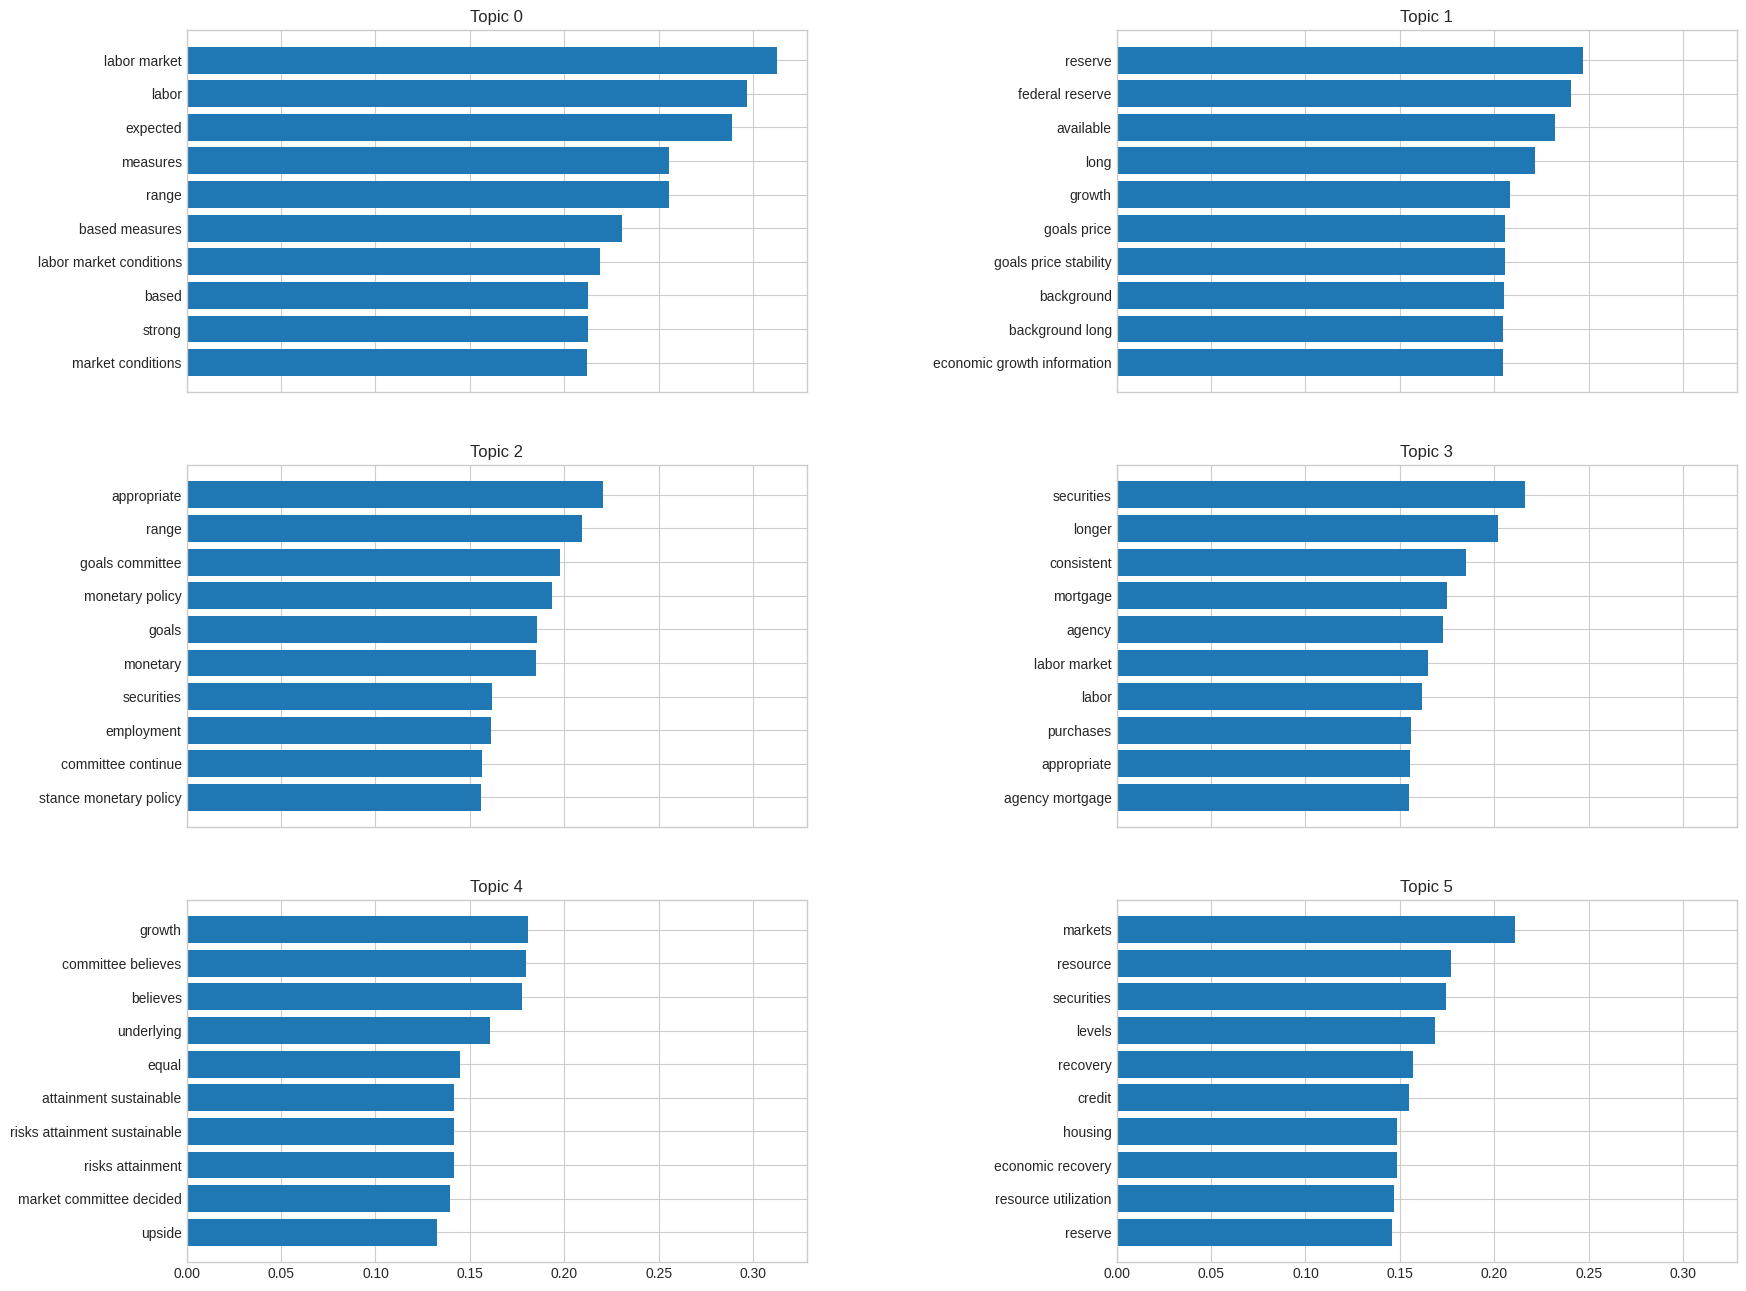

In [32]:
plot_word_embeddings(H2_)

Are these topics interesting? This is a matter of interpretation, but at least, the graph below shows that these topics capture a strong element of time-clustering which makes it a bit less useful.  

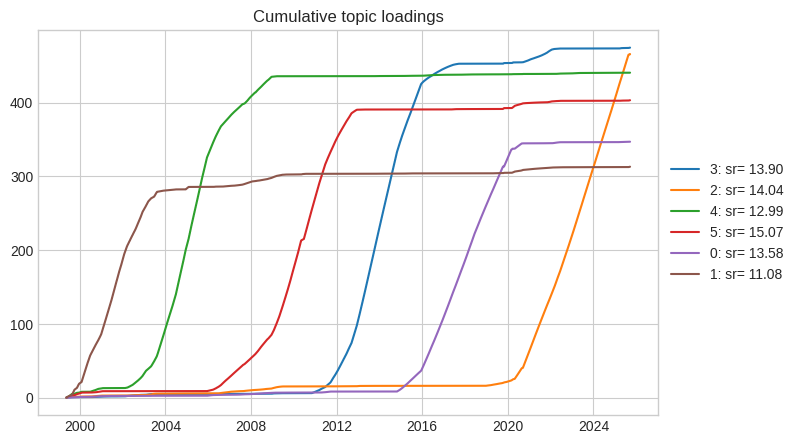

In [33]:
line(X_nmf.resample("B").last().ffill(), cumsum=True, title="Cumulative topic loadings")

## Deep-learning embeddings: sentence transformers

Deep-learning models have been used heavily to power NLP applications, in particular with `transformers` architecture starting with Delvin et al. (2018): "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding". Sentence Transformers are language models fined-tuned from pretrained language models to specifically generate meaningful text representations (as embeddings). 

- https://www.sbert.net/

In [34]:
from sentence_transformers import SentenceTransformer


def count_trainable_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

We use here a specific pretrained model and use it to derive embeddings for the corpus of Fed statements. 

In [35]:
lm_name = "all-distilroberta-v1"
m = SentenceTransformer(lm_name, device="cpu", trust_remote_code=True)
X_sbert = m.encode(statements["text"].values, batch_size=2)

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-distilroberta-v1


Batches:   0%|          | 0/114 [00:00<?, ?it/s]

In [36]:
print(
    f"Model card:\n - model name: {lm_name}\n - number of parameters: {count_trainable_parameters(m) / 1e6:.1f}m\n - embedding size: {m.get_sentence_embedding_dimension()}"
)

Model card:
 - model name: all-distilroberta-v1
 - number of parameters: 82.1m
 - embedding size: 768


## UMAP

Uniform Manifold Approximation and Projection (UMAP)  is a non-linear dimensionality reduction technique. It works by constructing a high-dimensional graph representation of the data and then optimizing a low-dimensional graph to be as structurally similar as possible. UMAP is useful because it effectively preserves both local and global structures in the data, which makes it particularly good for visualizing clusters and relationships in high-dimensional datasets.

- https://umap-learn.readthedocs.io/en/latest/

In [37]:
from umap import UMAP

In [38]:
embedding_ = UMAP().fit_transform(X_tfidf)
X_umap = pd.DataFrame(embedding_, index=statements.index)

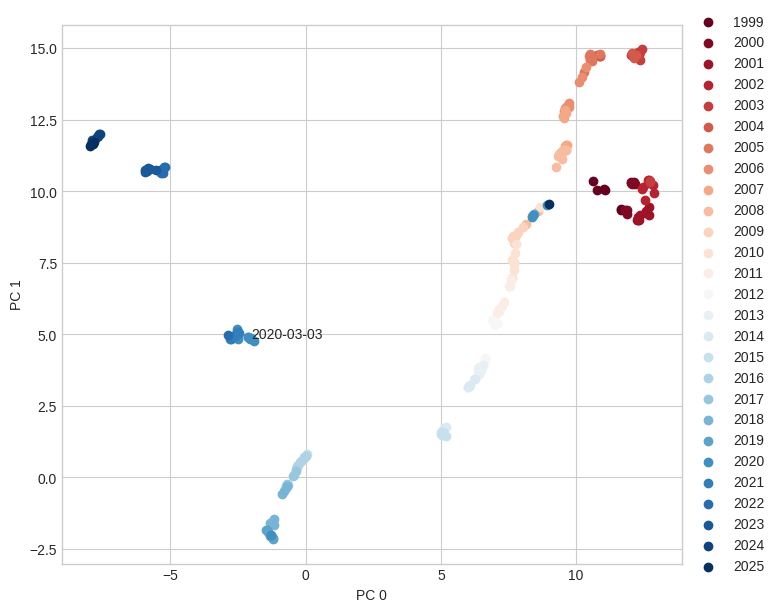

In [39]:
plot_document_embeddings(X_umap)